# Bayesian Optimisation: 1D test functions, Gaussian derived likelihoods and custom deterministic kernel

* This notebook provides a basic toolbox for the Bayesian optimisation using Gaussian processess framework as implemented in the pyro.contrib.gp module.
* The test functions used in the optimisation are 1D.
* The supported kernel is RBF.
* The supported acquisition function is a lower confidence bound.
* The tested `pyro.contrib.gp.models` are GPRegressor and VariationalGP. VariationalGP is tested with custom implementation of Gaussian likelihood.
* The censored data for the "wrong model" is supported: benchmark and Bayessian optimisation.



## Initiate the Notebook

In [279]:
!pip install -q pyro-ppl

In [280]:
import os

import torch
import torch.autograd as autograd
import torch.optim as optim
from torch.distributions import constraints, transform_to
from torch.nn import Parameter
from torch import nn

import numpy as np
import tqdm

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.nn.module import PyroParam, pyro_method
from pyro.contrib.gp.util import conditional
from pyro.distributions.util import eye_like

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns

smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.6')
pyro.set_rng_seed(0)
torch.set_default_tensor_type(torch.DoubleTensor)

# Data Generation



### Code

In [281]:
 def plot_data(noisy=False, censored=False, benchmark=False):
  # plots extended interval used for testing and investigating extrapolation
  plt.plot(X_test, y_test, label=fcn_dict[fcn_key_][0], linestyle="dotted")
  # plots the domain from which
  plt.plot(X, y, label='training domain', linestyle="dashed", color=sns.color_palette()[0])

  # the randomly sampled set to test the efficiency of Bayes Opt
  if benchmark==True:
    plt.scatter(X_train_benchmark, y_train_benchmark, label="observations - benchmark set",  alpha=0.85, color=sns.color_palette()[0], marker='*')
    if noisy==True:
      plt.scatter(X_train_benchmark, y_train_benchmark_noisy, label="noisy observations - benchmark set", s=25, alpha=0.55, color=sns.color_palette()[1], marker='*')
    if censored==True:
      plt.scatter(X_train_benchmark, y_train_benchmark_censored, label="observations censored - benchmark set", s=25, color=sns.color_palette()[2], marker='P')

  # plots the points used for initiating the Bayes optimiser
  plt.scatter(X_train, y_train, label="observations - initiate Bayes Opt",  alpha=0.65, color=sns.color_palette()[3])
  # perturbed observation
  if noisy==True:
    plt.scatter(X_train, y_train_noisy, label="noisy observations - initiate Bayes Opt", s=16, alpha=0.85, color=sns.color_palette()[1])
   # censored observation
  if censored==True:
    plt.scatter(X_train, y_train_censored, label="observations censored - initiate Bayes Opt", s=16, color=sns.color_palette()[4], marker='x')


  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.xlabel("$x$")
  plt.ylabel("$f(x)$")
  _ = plt.title("True generative process")

### 1-D Test Functions

We generate the different 1-D data points from a various test functions.
The test function is specifed in the dictionary and the parameters to specify are:
 * `start`: the lower bound of the interval from which we sample the x-axis grid   
 * `end`: the upper bound of the interval from which we sample the x-axis grid
 * `num_of_points`: num of equidistant points to cover the x-axis grid
 * `num_of_points_tes`: num of equdistant points for the x-axis grid in which we evaluate the predicted function
 * `padding`: length of the intraval added to lower and upper bound to extend the train x-axis grid, its used for testing and measuring the ability of the model to extrapolate outside the training regions  

In [282]:
# define function in the torch specific way
fcn1 = lambda x: 0.5 * torch.sin(3 * x)
fcn2 = lambda x: torch.pow((6 * x - 2),2)* torch.sin(2 * (6 * x - 2))
fcn3 = lambda x: torch.Tensor(x) * torch.sin(x)
fcn4 = lambda x: 0.5 * torch.sin(x) - 0.02 * torch.pow((10 - x), 2) + 2


fcn_dict = {
    # label, [start, end, num_of_points, num_of_points_test, padding for test region ], fcn
    'fcn1': ["$f(x) = 0.5 \sin(3x)$", [0, 5, 20, 200, 1], fcn1],
    'fcn2': ["$f(x) = (6x - 2)^2 \sin[2(6x - 2)]$", [0, 1, 30, 300, 0.2], fcn2],
    'fcn3': ["$f(x) = x \sin(x)$", [0, 10, 1000, 5000, 2], fcn3],
    'fcn4': ["$f(x) = 0.5 \sin(x) - 0.02(10 - x)^2 + 2$", [0, 20, 1000, 5000, 5], fcn3]
    }

In [283]:
# set hyperparameters for data generation

fcn_key_ = 'fcn2' # select function
noise_std = 0.2 # add noise

N = 4 # number of training data points
N_benchmark = 30 # the total budget of the points available for the fitting

# set perscentile corresponding to the treshold --> values smaller than given treshold are assigned treshold value
# if set to 0, no censoring is applied
treshold = 20

__Generated variables__

*   variable X is x-axis grid over which the values of the function f(x) are being computed  
*   variable y correspond to f(x) values
* (X_train, y_train) is uniformly subsampled N points used for initiating the Bayesian optimisation
* (X_train, y_train_noisy) is uniformly subsampled N points used for initiating the Bayesian optimisation with mixed in Gaussian noise with variance specified
in variable noise_std, i.e. corresponds to the perturbed initial data
* (X_train_benchmark, y_train_benchmark_noisy) is uniformly subsampled N_benchmark points used for benchamriking the Bayesian optimiser against the uniformly randomly sampled points with N_benchmark - N corresponding to the number of steps in Bayes optimisation
* X_test is x-grid which has extra padding on both side outside the train interval to test the ability of the model to extrapolate
* (X_test, y_test) fucntion f(x) computed on the testing interval X_test

In [284]:
# generate data
# get grid
X = np.linspace(
    start=fcn_dict[fcn_key_][1][0],
    stop=fcn_dict[fcn_key_][1][1],
    num=fcn_dict[fcn_key_][1][2]).reshape(-1, 1)

# apply selected function
temp_y = fcn_dict[fcn_key_][2](torch.Tensor(X))
y = np.squeeze(temp_y.numpy())

# sample training set for initiating the Bayesion optimisation
X_train = dist.Uniform(fcn_dict[fcn_key_][1][0], fcn_dict[fcn_key_][1][1]).sample(sample_shape=(N,))
y_train = fcn_dict[fcn_key_][2](torch.Tensor(X_train))
# mix in normal noise
y_train_noisy = y_train + dist.Normal(0.0, noise_std).sample(sample_shape=(N,))

# sample training set for initiating the Bayesion optimisation
X_train_benchmark = dist.Uniform(fcn_dict[fcn_key_][1][0], fcn_dict[fcn_key_][1][1]).sample(sample_shape=(N_benchmark,))
y_train_benchmark = fcn_dict[fcn_key_][2](torch.Tensor(X_train_benchmark))
# mix in normal noise
y_train_benchmark_noisy = y_train_benchmark + dist.Normal(0.0, noise_std).sample(sample_shape=(N_benchmark,))

X_test = np.squeeze(np.linspace(
    start=fcn_dict[fcn_key_][1][0] - fcn_dict[fcn_key_][1][4],
    stop=fcn_dict[fcn_key_][1][1] + fcn_dict[fcn_key_][1][4],
    num=fcn_dict[fcn_key_][1][3]))

temp_y_test = fcn_dict[fcn_key_][2](torch.Tensor(X_test))
y_test = np.squeeze(temp_y_test.numpy())

### Censoring
* compute bound for a given percentile and replaces all values smaller than the bound with the bound value
* `censoring_id` is an identifier indicating positions of the values on which the censoring was applied  

In [285]:
# apply censoring
censor = lambda x: np.clip(x, lower_cf, None)

# def get_censoring_ids()

lower_cf = np.percentile(y_train, treshold)
print(lower_cf)
y_train_censored = censor(y_train)
y_train_noisy_censored = censor(y_train_noisy)
y_train_benchmark_censored = censor(y_train_benchmark)
y_train_benchmark_noisy_censored = censor(y_train_benchmark_noisy)

censoring_id = np.zeros(len(y_train))
np.put(censoring_id, np.where(y_train_censored!=y_train), 1)

-1.6288103236493698


In [286]:
y_train

tensor([14.2639, -4.9286,  0.5710,  8.6097])

In [287]:
y_train_censored

tensor([14.2639, -1.6288,  0.5710,  8.6097])

In [288]:
censoring_id

array([0., 1., 0., 0.])

### Visualise the dataset

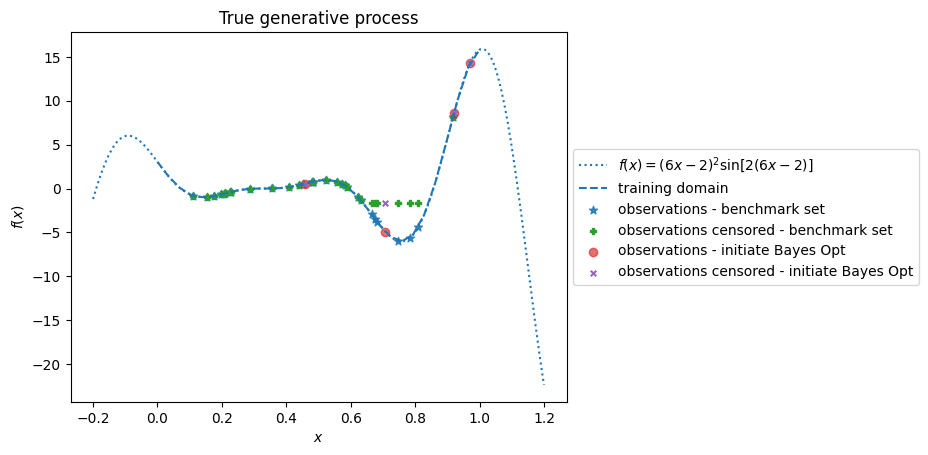

In [289]:
plot_data(noisy=False, benchmark=True, censored=True)

# Experiments

## Code

### Training GPs

In [340]:
def is_var(gpmodel):
  if type(gpmodel) == gp.models.VariationalSparseGP or type(gpmodel) == gp.models.VariationalGP:
    res = True
  else:
    res = False
  return res

def torch_backward(x, retain_graph=None):
    """
    Like ``x.backward()`` for a :class:`~torch.Tensor`, but also accepts
    numbers and tensors without grad_fn (resulting in a no-op)
    """
    if torch.is_tensor(x) and x.grad_fn:
        x.backward(retain_graph=retain_graph)

def optimise(gpmodel, num_steps = 2000, lr_=0.005, MeanFieldElbo=False, clear_param=True, retain_graph=None):
  if clear_param==True:
    pyro.clear_param_store()

  # TODO: redesign this code to suppport different loss functions and optimisers
  optimizer = torch.optim.Adam(gpmodel.parameters(), lr=lr_)
  if MeanFieldElbo==True:
      loss_fn = pyro.infer.TraceMeanField_ELBO().differentiable_loss
  else:
      loss_fn = pyro.infer.Trace_ELBO().differentiable_loss

  # optimisation step
  def closure():
      optimizer.zero_grad()
      loss = loss_fn(gpmodel.model, gpmodel.guide)
      torch_backward(loss, retain_graph)
      return loss

  # TODO: add flag to monitor the performance on train and validation set
  # TODO: rewrite the code such that it supports different kernels than RBF hyperparameters
  losses = []
  variances = []
  lengthscales = []
  noises = []

  pbar = tqdm.tqdm(range(num_steps), position=0, leave=True)

  for epoch in pbar:
      # store outputs from the optimisation
      variances.append(gpmodel.kernel.variance.item())
      lengthscales.append(gpmodel.kernel.lengthscale.item())
      if is_var(gpmodel)==True:
        noises.append(gpmodel.likelihood.variance.item())
      else:
        noises.append(gpmodel.noise.item())

      loss = optimizer.step(closure)
      losses.append(loss.item())

  # prints learnt parameters of the kernel
  gpmodel.set_mode("guide")
  print("\nvariance = {: .6f}".format(gpmodel.kernel.variance))
  print("lengthscale = {: .6f}".format(gpmodel.kernel.lengthscale))
  if is_var(gpmodel)==True:
    print("noise = {: .6f}".format(gpmodel.likelihood.variance))
  else:
    print("noise = {: .6f}".format(gpmodel.noise))

  res = {'model': gpmodel,
          'losses' : losses,
          'variances' : variances,
          'lengthscales' : lengthscales,
          'noises' : noises}
  return res

In [341]:
def visualise_training(kwargs):
  temp = kwargs.copy()
  if 'model' in temp.keys():
    model_ =  temp.pop('model')
  n = len(temp)
  fig, ax = plt.subplots(1, n, figsize=(4*n, 3))
  for idx, (key, val) in enumerate(temp.items()):
      ax[idx].plot(val)
      ax[idx].set_title('{}: {: .4f}'.format(key, val[-1]))


def mse(predicted, labels):
    res = torch.mean((predicted - labels) ** 2)
    return res

def rmse(predicted, labels):
    res = torch.sqrt(mse(predicted, labels))
    return res

def visualise_results(model, grid=X_train, labels=y_train, censored=None, title_=' '):
  with torch.no_grad():
    mean, cov = model.forward(torch.Tensor(X_test), full_cov=True)
    mean_train, cov_train = model.forward(torch.Tensor(np.squeeze(X)), full_cov=True)
  sd = cov.diag().sqrt().numpy()
  rmse_train = rmse(mean_train, torch.Tensor(y)).numpy()
  rmse_test = rmse(mean, torch.Tensor(y_test)).numpy()

  title_ = '{}\nrmse train: {: .4f}, rmse test: {: .4f}'.format(title_, rmse_train, rmse_test)
  plt.plot(X_test, y_test, label=fcn_dict[fcn_key_][0], linestyle="dotted")
  plt.plot(X, y, label='training domain', linestyle="dashed", color=sns.color_palette()[0])
  plt.scatter(grid, labels, label="training observations")
  plt.plot(X_test, mean.numpy(), label="mean prediction")
  if censored is not None:
    plt.scatter(grid, censored, label="censored observations", s=16, alpha=0.85, color=sns.color_palette()[2], marker='x')
  plt.fill_between(
      X_test.ravel(),
      mean.numpy() - 1.96 * sd,
      mean.numpy() + 1.96 * sd,
      alpha=0.3,
      label=r"95% confidence interval",
  )
  plt.legend()
  plt.xlabel("$x$")
  plt.ylabel("$f(x)$")
  _ = plt.title(title_)
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text


def  is_var(model):
  if type(model) == gp.models.VariationalSparseGP or type(model) == gp.models.VariationalGP:
    res = True
  else:
    res = False
  return res
def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text

def visualise_trajectories(gpmodel, fcn_key_, samples):
  num_test_grid = fcn_dict[fcn_key_][1][3]
  noise = (gpmodel.likelihood.variance if is_var(gpmodel) else gpmodel.noise)
  cov = gpmodel.kernel.forward(torch.Tensor(X_test)) + noise.expand(num_test_grid).diag()
  samples = dist.MultivariateNormal(
              torch.zeros(num_test_grid), covariance_matrix=cov).sample(sample_shape=(samples,))
  fig, ax = plt.subplots(figsize=(8, 3))
  _ = ax.plot(X_test, samples.T, lw=2, alpha=0.4)
  _ = plt.title('variance: {: .4f}, lengthscale: {: .4f}'.format(gpmodel.kernel.variance.item(), gpmodel.kernel.lengthscale.item()))

In [292]:
from pyro.contrib.gp.likelihoods.likelihood import Likelihood
from pyro.nn.module import PyroParam, pyro_method

class Gaussian(Likelihood):
    def __init__(self, variance=None):
        super().__init__()

        variance = torch.tensor(1.) if variance is None else variance
        self.variance = PyroParam(variance, constraints.positive)

    def forward(self, f_loc, f_var, y=None):
        y_dist = dist.Normal(f_loc + torch.randn(f_loc.dim(), device=f_loc.device)*f_var, self.variance.sqrt())
        self.y_dist = y_dist
        if y is not None:
            y_dist = y_dist.expand_by(y.shape[:-f_loc.dim()]).to_event(y.dim())
        return pyro.sample(self._pyro_get_fullname("y"), y_dist, obs=y)

### Bayesian Optimisation

In [293]:
def bayes_optimiser(gpmodel, fcn_key_, steps, update_posterior_steps=1000, kappa_=1.96):
  """
  1. Takes the gpmodel and optimise it for the initial set of points
  2. For step in steps repeat:
    - select the new candidate point to be evaluated by evaluating the acquisition function
    -
  """
  #----- helper functions --------
  def update_posterior(x_new):
      y = fcn_dict[fcn_key_][2](torch.Tensor(x_new)) # evaluate f at new point.
      X = torch.cat([gpmodel.X, torch.Tensor(x_new)]) # incorporate new evaluation
      y = torch.cat([gpmodel.y, y])
      print(X, y)
      gpmodel.set_data(X, y)
      # optimize the GP hyperparameters using Adam with lr=0.001
      print(gpmodel.X)
      # TODO: fix the bug for VariationalGP
      optimise(gpmodel, num_steps=update_posterior_steps, clear_param=False)

  # acquisition function
  def lower_confidence_bound(x, kappa=kappa_):
      mean, cov = gpmodel.forward(torch.Tensor(x), full_cov=True, noiseless=False) if is_var(gpmodel)==False else  gpmodel.forward(torch.Tensor(x), full_cov=True)
      sd = cov.diag().sqrt()
      return mean - kappa * sd

  def find_a_candidate(x_init, lower_bound, upper_bound):
      # transform x to an unconstrained domain
      constraint = constraints.interval(lower_bound, upper_bound)
      unconstrained_x_init = transform_to(constraint).inv(x_init)
      unconstrained_x = unconstrained_x_init.clone().detach().requires_grad_(True)
      minimizer = optim.LBFGS([unconstrained_x], line_search_fn='strong_wolfe')

      def closure():
          minimizer.zero_grad()
          x = transform_to(constraint)(unconstrained_x)
          y = lower_confidence_bound(x)
          autograd.backward(unconstrained_x, autograd.grad(y, unconstrained_x))
          return y

      minimizer.step(closure)
      # after finding a candidate in the unconstrained domain,
      # convert it back to original domain.
      x = transform_to(constraint)(unconstrained_x)
      return x.detach()

  def next_x(lower_bound, upper_bound, num_candidates=5):
      candidates = []
      values = []

      x_init = gpmodel.X[-1:]
      for i in range(num_candidates):
          x = find_a_candidate(x_init, lower_bound, upper_bound)
          # evaluate using acquisiton function
          y = lower_confidence_bound(x)
          candidates.append(x)
          values.append(y)
          x_init = x.new_empty(1).uniform_(lower_bound, upper_bound)

      argmin = torch.min(torch.cat(values), dim=0)[1].item()
      return candidates[argmin]

  # ------- main body -----
  # main initialisation
  eps = 1e-04
  lower_bound_ = fcn_dict[fcn_key_][1][0]
  upper_bound_ = fcn_dict[fcn_key_][1][1]
  gpr_res = optimise(gpmodel)
  pbar = tqdm.tqdm(range(steps), position=0, leave=True)

  xmin = []
  variance = []
  lenghtscale = []
  variance.append(gpmodel.kernel.variance.item())
  lenghtscale.append(gpmodel.kernel.lengthscale.item())

  print("--- Starting optimisation: ----")
  for epoch in pbar:
    xmin_ = next_x(lower_bound=lower_bound_, upper_bound=upper_bound_)
    print('Selected xmin: {}'.format(xmin_.item()))
    if xmin_ in gpmodel.X:
      xmin_ = xmin_ + eps
    xmin.append(xmin_.item())

    update_posterior(xmin_)
    variance.append(gpmodel.kernel.variance.item())
    lenghtscale.append(gpmodel.kernel.lengthscale.item())

  res = {'model': gpmodel,
         'x_seq': xmin,
         'variance': variance,
         'lengthscale': lenghtscale
  }
  return res


In [294]:
# pyro.clear_param_store()

# print(gpr.kernel.variance.item(), gpr.kernel.lengthscale.item())
# gpr_res = optimise(gpr)

# for i in range(8):
#     print('------- iter: %s --------'%i)
#     xmin = next_x()
#     print(xmin)
#     print(gpr.kernel.variance.item(), gpr.kernel.lengthscale.item())
#     try:
#       plt.figure()
#       visualise_trajectories(gpr, fcn_key_, 3)
#       plt.show()
#     except:
#       pass
#     plt.figure()
#     visualise_results(gpr)
#     plt.show()
#     update_posterior(xmin)

## 1. GPRegression

This section uses the `gp.models.GPRegression` object on the on the non-censored and censored data to provide the intuition into the impact of the censoring on the Bayesian optimisation.

We have chosen:
  * the radial kernel
  * lower confidence bound acquisition function

### Non-censored data
The benchmark values for the GP if the data were observed fully.

#### Benchmark

In [295]:
# set parameters for RBF kernel
pyro.clear_param_store()

var_ = 6.
lengthscale_ = 0.05

kernel_benchmark = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(var_), lengthscale=torch.tensor(lengthscale_))
gpr_benchmark = gp.models.GPRegression(torch.Tensor(X_train_benchmark), torch.Tensor(y_train_benchmark), kernel_benchmark)

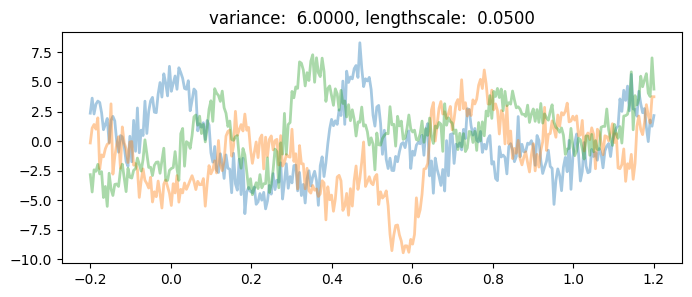

In [296]:
visualise_trajectories(gpr_benchmark, fcn_key_, 3)

In [297]:
gpr_benchmark_res = optimise(gpr_benchmark)

100%|██████████| 2000/2000 [00:25<00:00, 78.80it/s]


variance =  143.236076
lengthscale =  0.192048
noise =  0.000044


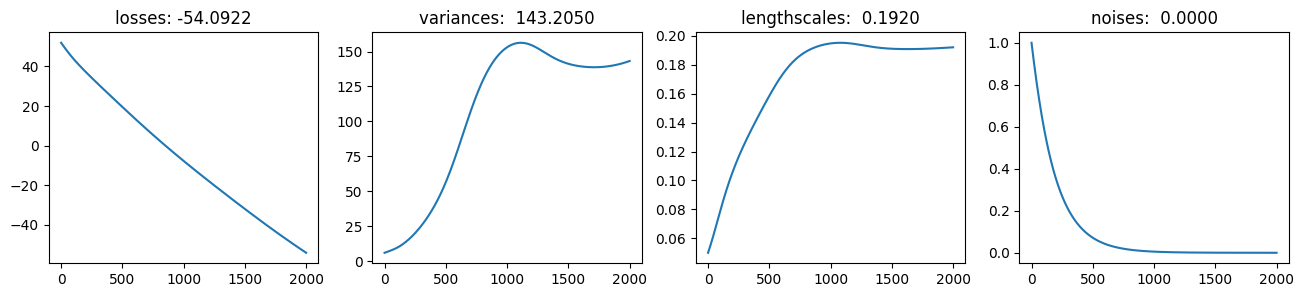

In [298]:
visualise_training(gpr_benchmark_res)

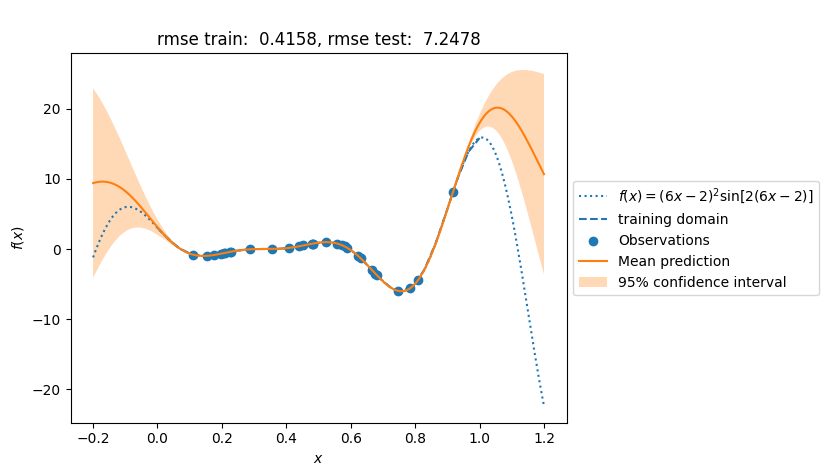

In [299]:
visualise_results(gpr_benchmark_res['model'], grid=X_train_benchmark, labels=y_train_benchmark)

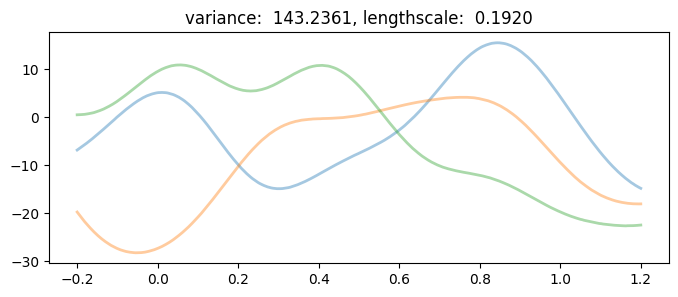

In [300]:
visualise_trajectories(gpr_benchmark, fcn_key_, 3)

#### Bayes Optimisation

In [301]:
# set parameters for RBF kernel
pyro.clear_param_store()

var_ = 6.
lengthscale_ = 0.05

kernel = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(var_), lengthscale=torch.tensor(lengthscale_))
gpr = gp.models.GPRegression(torch.Tensor(X_train), torch.Tensor(y_train), kernel)

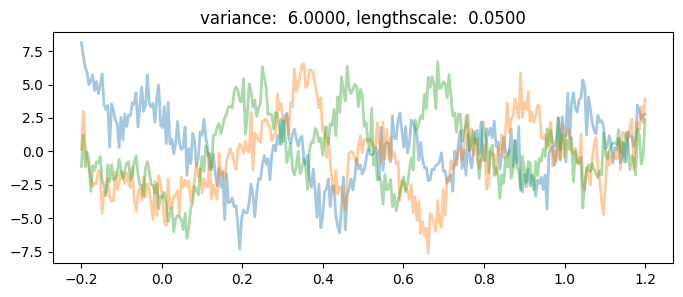

In [302]:
visualise_trajectories(gpr, fcn_key_, 3)

In [303]:
steps_ = N_benchmark - N
print(steps_)
bayes_res = bayes_optimiser(gpr, fcn_key_, steps=steps_)

26


100%|██████████| 2000/2000 [00:10<00:00, 186.50it/s]



variance =  55.042846
lengthscale =  0.097376
noise =  6.174800


  0%|          | 0/26 [00:00<?, ?it/s]

--- Starting optimisation: ----
Selected xmin: 0.00013593995395740622
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04]) tensor([14.2639, -4.9286,  0.5710,  8.6097,  3.0205])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04])


  4%|▍         | 1/26 [00:05<02:19,  5.60s/it]


variance =  44.994538
lengthscale =  0.084536
noise =  4.787759
Selected xmin: 0.2477577751907206
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01]) tensor([14.2639, -4.9286,  0.5710,  8.6097,  3.0205, -0.2256])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01])


  8%|▊         | 2/26 [00:11<02:21,  5.90s/it]


variance =  36.331477
lengthscale =  0.079167
noise =  4.425331
Selected xmin: 0.6133551942874387
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01]) tensor([14.2639, -4.9286,  0.5710,  8.6097,  3.0205, -0.2256, -0.6124])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01])


 12%|█▏        | 3/26 [00:17<02:11,  5.72s/it]


variance =  32.792685
lengthscale =  0.107809
noise =  4.945511
Selected xmin: 0.7553987500858067
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01]) tensor([14.2639, -4.9286,  0.5710,  8.6097,  3.0205, -0.2256, -0.6124, -6.0189])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01])


 15%|█▌        | 4/26 [00:23<02:12,  6.04s/it]


variance =  67.258896
lengthscale =  0.153642
noise =  0.064116
Selected xmin: 0.7584646961156678
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01]) tensor([14.2639, -4.9286,  0.5710,  8.6097,  3.0205, -0.2256, -0.6124, -6.0189,
        -6.0199])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01])


 19%|█▉        | 5/26 [00:29<02:01,  5.80s/it]


variance =  65.777909
lengthscale =  0.153603
noise =  0.000591
Selected xmin: 0.7564338384671594
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01]) tensor([14.2639, -4.9286,  0.5710,  8.6097,  3.0205, -0.2256, -0.6124, -6.0189,
        -6.0199, -6.0204])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01])


 23%|██▎       | 6/26 [00:35<01:59,  6.00s/it]


variance =  65.740604
lengthscale =  0.155559
noise =  0.000007
Selected xmin: 0.7566703722604244
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01]) tensor([14.2639, -4.9286,  0.5710,  8.6097,  3.0205, -0.2256, -0.6124, -6.0189,
        -6.0199, -6.0204, -6.0206])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01])


 27%|██▋       | 7/26 [00:41<01:53,  5.96s/it]


variance =  64.148652
lengthscale =  0.154184
noise =  0.000000
Selected xmin: 0.7574840228680718
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01]) tensor([14.2639, -4.9286,  0.5710,  8.6097,  3.0205, -0.2256, -0.6124, -6.0189,
        -6.0199, -6.0204, -6.0206, -6.0207])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01])


 31%|███       | 8/26 [00:50<02:02,  6.82s/it]


variance =  64.023090
lengthscale =  0.154058
noise =  0.000000
Selected xmin: 0.7575089775983392
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01]) tensor([14.2639, -4.9286,  0.5710,  8.6097,  3.0205, -0.2256, -0.6124, -6.0189,
        -6.0199, -6.0204, -6.0206, -6.0207, -6.0207])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01])


 35%|███▍      | 9/26 [00:58<02:06,  7.46s/it]


variance =  63.997018
lengthscale =  0.154032
noise =  0.000000
Selected xmin: 0.7574478709924412
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01]) tensor([14.2639, -4.9286,  0.5710,  8.6097,  3.0205, -0.2256, -0.6124, -6.0189,
        -6.0199, -6.0204, -6.0206, -6.0207, -6.0207, -6.0207])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01])


 38%|███▊      | 10/26 [01:08<02:10,  8.13s/it]


variance =  63.987223
lengthscale =  0.154022
noise =  0.000000
Selected xmin: 0.7573811853028569
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01, 7.5738e-01]) tensor([14.2639, -4.9286,  0.5710,  8.6097,  3.0205, -0.2256, -0.6124, -6.0189,
        -6.0199, -6.0204, -6.0206, -6.0207, -6.0207, -6.0207, -6.0207])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01, 7.5738e-01])


 42%|████▏     | 11/26 [01:16<02:00,  8.01s/it]


variance =  63.983104
lengthscale =  0.154018
noise =  0.000000
Selected xmin: 0.7573231558056138
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01, 7.5738e-01, 7.5732e-01]) tensor([14.2639, -4.9286,  0.5710,  8.6097,  3.0205, -0.2256, -0.6124, -6.0189,
        -6.0199, -6.0204, -6.0206, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01, 7.5738e-01, 7.5732e-01])


 46%|████▌     | 12/26 [01:22<01:42,  7.32s/it]


variance =  63.981484
lengthscale =  0.154017
noise =  0.000000
Selected xmin: 0.7572661974171752
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01, 7.5738e-01, 7.5732e-01, 7.5727e-01]) tensor([14.2639, -4.9286,  0.5710,  8.6097,  3.0205, -0.2256, -0.6124, -6.0189,
        -6.0199, -6.0204, -6.0206, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207,
        -6.0207])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01, 7.5738e-01, 7.5732e-01, 7.5727e-01])


 50%|█████     | 13/26 [01:28<01:32,  7.11s/it]


variance =  63.981088
lengthscale =  0.154017
noise =  0.000000
Selected xmin: 0.7572119048003374
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01, 7.5738e-01, 7.5732e-01, 7.5727e-01, 7.5721e-01]) tensor([14.2639, -4.9286,  0.5710,  8.6097,  3.0205, -0.2256, -0.6124, -6.0189,
        -6.0199, -6.0204, -6.0206, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207,
        -6.0207, -6.0207])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01, 7.5738e-01, 7.5732e-01, 7.5727e-01, 7.5721e-01])


 54%|█████▍    | 14/26 [01:34<01:20,  6.72s/it]


variance =  63.981138
lengthscale =  0.154017
noise =  0.000000
Selected xmin: 0.757163710604891
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01, 7.5738e-01, 7.5732e-01, 7.5727e-01, 7.5721e-01,
        7.5716e-01]) tensor([14.2639, -4.9286,  0.5710,  8.6097,  3.0205, -0.2256, -0.6124, -6.0189,
        -6.0199, -6.0204, -6.0206, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207,
        -6.0207, -6.0207, -6.0207])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01, 7.5738e-01, 7.5732e-01, 7.5727e-01, 7.5721e-01,
        7.5716e-01])


 58%|█████▊    | 15/26 [01:40<01:11,  6.54s/it]


variance =  63.981169
lengthscale =  0.154017
noise =  0.000000
Selected xmin: 0.7571337956709144
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01, 7.5738e-01, 7.5732e-01, 7.5727e-01, 7.5721e-01,
        7.5716e-01, 7.5713e-01]) tensor([14.2639, -4.9286,  0.5710,  8.6097,  3.0205, -0.2256, -0.6124, -6.0189,
        -6.0199, -6.0204, -6.0206, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207,
        -6.0207, -6.0207, -6.0207, -6.0207])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01, 7.5738e-01, 7.5732e-01, 7.5727e-01, 7.5721e-01,
        7.5716e-01, 7.5713e-01])


 62%|██████▏   | 16/26 [01:47<01:05,  6.56s/it]


variance =  63.981050
lengthscale =  0.154017
noise =  0.000000
Selected xmin: 0.7573682594732369
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01, 7.5738e-01, 7.5732e-01, 7.5727e-01, 7.5721e-01,
        7.5716e-01, 7.5713e-01, 7.5737e-01]) tensor([14.2639, -4.9286,  0.5710,  8.6097,  3.0205, -0.2256, -0.6124, -6.0189,
        -6.0199, -6.0204, -6.0206, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207,
        -6.0207, -6.0207, -6.0207, -6.0207, -6.0207])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01, 7.5738e-01, 7.5732e-01, 7.5727e-01, 7.5721e-01,
        7.5716e-01, 7.5713e-01, 7.5737e-01])


 65%|██████▌   | 17/26 [01:52<00:56,  6.31s/it]


variance =  63.978772
lengthscale =  0.154014
noise =  0.000000
Selected xmin: 0.7568705948857386
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01, 7.5738e-01, 7.5732e-01, 7.5727e-01, 7.5721e-01,
        7.5716e-01, 7.5713e-01, 7.5737e-01, 7.5687e-01]) tensor([14.2639, -4.9286,  0.5710,  8.6097,  3.0205, -0.2256, -0.6124, -6.0189,
        -6.0199, -6.0204, -6.0206, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207,
        -6.0207, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01, 7.5738e-01, 7.5732e-01, 7.5727e-01, 7.5721e-01,
        7.5716e-01, 7.5713e-01, 7.5737e-01, 7.5687e-01])


 69%|██████▉   | 18/26 [01:59<00:50,  6.33s/it]


variance =  63.972128
lengthscale =  0.154007
noise =  0.000000
Selected xmin: 0.7574898576622173
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01, 7.5738e-01, 7.5732e-01, 7.5727e-01, 7.5721e-01,
        7.5716e-01, 7.5713e-01, 7.5737e-01, 7.5687e-01, 7.5749e-01]) tensor([14.2639, -4.9286,  0.5710,  8.6097,  3.0205, -0.2256, -0.6124, -6.0189,
        -6.0199, -6.0204, -6.0206, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207,
        -6.0207, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01, 7.5738e-01, 7.5732e-01, 7.5727e-01, 7.5721e-01,
        7.5716e-01, 7.5713e-01, 7.5737e-01, 7.5687e-01, 7.5749e-01])


 73%|███████▎  | 19/26 [02:04<00:42,  6.09s/it]


variance =  63.965608
lengthscale =  0.154001
noise =  0.000000
Selected xmin: 0.7568404204998919
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01, 7.5738e-01, 7.5732e-01, 7.5727e-01, 7.5721e-01,
        7.5716e-01, 7.5713e-01, 7.5737e-01, 7.5687e-01, 7.5749e-01, 7.5684e-01]) tensor([14.2639, -4.9286,  0.5710,  8.6097,  3.0205, -0.2256, -0.6124, -6.0189,
        -6.0199, -6.0204, -6.0206, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207,
        -6.0207, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01, 7.5738e-01, 7.5732e-01, 7.5727e-01, 7.5721e-01,
        7.5716e-01, 7.5713e-01, 7.5737e-01, 7.5687e-01, 7.5749e-01, 7.5684e-01])


 77%|███████▋  | 20/26 [02:11<00:37,  6.21s/it]


variance =  63.958136
lengthscale =  0.153993
noise =  0.000000
Selected xmin: 0.7575243100124811
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01, 7.5738e-01, 7.5732e-01, 7.5727e-01, 7.5721e-01,
        7.5716e-01, 7.5713e-01, 7.5737e-01, 7.5687e-01, 7.5749e-01, 7.5684e-01,
        7.5752e-01]) tensor([14.2639, -4.9286,  0.5710,  8.6097,  3.0205, -0.2256, -0.6124, -6.0189,
        -6.0199, -6.0204, -6.0206, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207,
        -6.0207, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207,
        -6.0207])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01, 7.5738e-01, 7.5732e-01, 7.5727e-01, 7.5721e-01,
        7.5716e-01, 7.5713e-01, 7.5737e-01, 7.5687e-01, 7.5749

 81%|████████  | 21/26 [02:17<00:30,  6.07s/it]


variance =  63.950548
lengthscale =  0.153985
noise =  0.000000
Selected xmin: 0.7568298257906547
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01, 7.5738e-01, 7.5732e-01, 7.5727e-01, 7.5721e-01,
        7.5716e-01, 7.5713e-01, 7.5737e-01, 7.5687e-01, 7.5749e-01, 7.5684e-01,
        7.5752e-01, 7.5683e-01]) tensor([14.2639, -4.9286,  0.5710,  8.6097,  3.0205, -0.2256, -0.6124, -6.0189,
        -6.0199, -6.0204, -6.0206, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207,
        -6.0207, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207,
        -6.0207, -6.0206])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01, 7.5738e-01, 7.5732e-01, 7.5727e-01, 7.5721e-01,
        7.5716e-01, 7.5713e-01, 7.5737e-0

 85%|████████▍ | 22/26 [02:23<00:24,  6.22s/it]


variance =  63.943150
lengthscale =  0.153977
noise =  0.000000
Selected xmin: 0.7575411906247825
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01, 7.5738e-01, 7.5732e-01, 7.5727e-01, 7.5721e-01,
        7.5716e-01, 7.5713e-01, 7.5737e-01, 7.5687e-01, 7.5749e-01, 7.5684e-01,
        7.5752e-01, 7.5683e-01, 7.5754e-01]) tensor([14.2639, -4.9286,  0.5710,  8.6097,  3.0205, -0.2256, -0.6124, -6.0189,
        -6.0199, -6.0204, -6.0206, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207,
        -6.0207, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207,
        -6.0207, -6.0206, -6.0207])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01, 7.5738e-01, 7.5732e-01, 7.5727e-01, 7.5721e-01,
        7.5716e-01, 

 88%|████████▊ | 23/26 [02:29<00:18,  6.01s/it]


variance =  63.935378
lengthscale =  0.153969
noise =  0.000000
Selected xmin: 0.756826868595446
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01, 7.5738e-01, 7.5732e-01, 7.5727e-01, 7.5721e-01,
        7.5716e-01, 7.5713e-01, 7.5737e-01, 7.5687e-01, 7.5749e-01, 7.5684e-01,
        7.5752e-01, 7.5683e-01, 7.5754e-01, 7.5683e-01]) tensor([14.2639, -4.9286,  0.5710,  8.6097,  3.0205, -0.2256, -0.6124, -6.0189,
        -6.0199, -6.0204, -6.0206, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207,
        -6.0207, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207,
        -6.0207, -6.0206, -6.0207, -6.0206])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01, 7.5738e-01, 7.5732e-01, 7.5727e-01, 7.5721e-01,


 92%|█████████▏| 24/26 [02:35<00:12,  6.04s/it]


variance =  63.928338
lengthscale =  0.153962
noise =  0.000000
Selected xmin: 0.7575497010733762
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01, 7.5738e-01, 7.5732e-01, 7.5727e-01, 7.5721e-01,
        7.5716e-01, 7.5713e-01, 7.5737e-01, 7.5687e-01, 7.5749e-01, 7.5684e-01,
        7.5752e-01, 7.5683e-01, 7.5754e-01, 7.5683e-01, 7.5755e-01]) tensor([14.2639, -4.9286,  0.5710,  8.6097,  3.0205, -0.2256, -0.6124, -6.0189,
        -6.0199, -6.0204, -6.0206, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207,
        -6.0207, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207,
        -6.0207, -6.0206, -6.0207, -6.0206, -6.0207])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01, 7.5738e-01, 7.5732e-01, 7.

 96%|█████████▌| 25/26 [02:41<00:06,  6.09s/it]


variance =  63.920814
lengthscale =  0.153954
noise =  0.000000
Selected xmin: 0.7568290907531814
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01, 7.5738e-01, 7.5732e-01, 7.5727e-01, 7.5721e-01,
        7.5716e-01, 7.5713e-01, 7.5737e-01, 7.5687e-01, 7.5749e-01, 7.5684e-01,
        7.5752e-01, 7.5683e-01, 7.5754e-01, 7.5683e-01, 7.5755e-01, 7.5683e-01]) tensor([14.2639, -4.9286,  0.5710,  8.6097,  3.0205, -0.2256, -0.6124, -6.0189,
        -6.0199, -6.0204, -6.0206, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207,
        -6.0207, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207, -6.0207,
        -6.0207, -6.0206, -6.0207, -6.0206, -6.0207, -6.0206])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 1.3594e-04, 2.4776e-01,
        6.1336e-01, 7.5540e-01, 7.5846e-01, 7.5643e-01, 7.5667e-01, 7.5748e-01,
        7.5751e-01, 7.5745e-01, 7.573

100%|██████████| 26/26 [02:47<00:00,  6.45s/it]


variance =  63.914291
lengthscale =  0.153947
noise =  0.000000


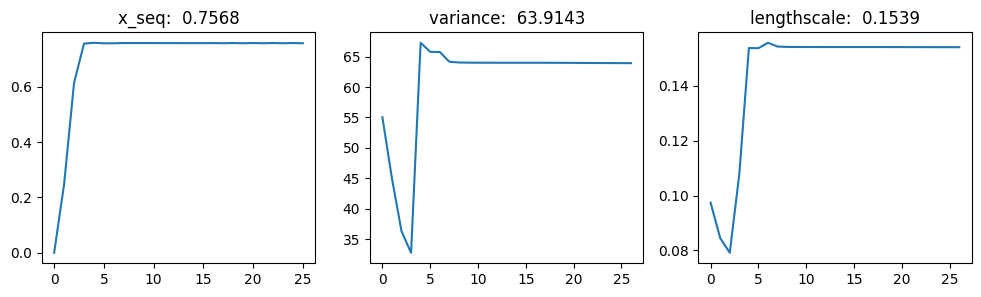

In [304]:
visualise_training(bayes_res)

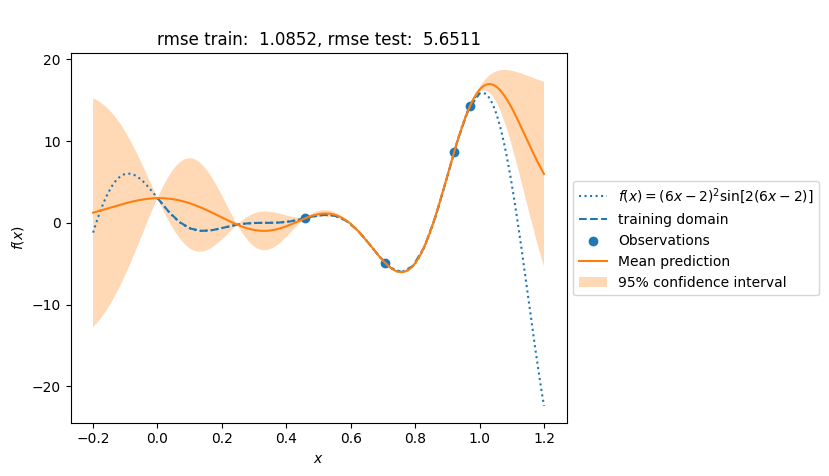

In [305]:
visualise_results(bayes_res['model'])

### Censored data

Applying "wrong modelling approach" to the censored data, i.e. neglecting the censoring.

#### Benchmark

In [306]:
pyro.clear_param_store()

var_ = 6.
lengthscale_ = 0.05

kernel_benchmark_censored = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(var_), lengthscale=torch.tensor(lengthscale_))
gpr_benchmark_censored = gp.models.GPRegression(torch.Tensor(X_train_benchmark), torch.Tensor(y_train_benchmark_censored), kernel_benchmark_censored)

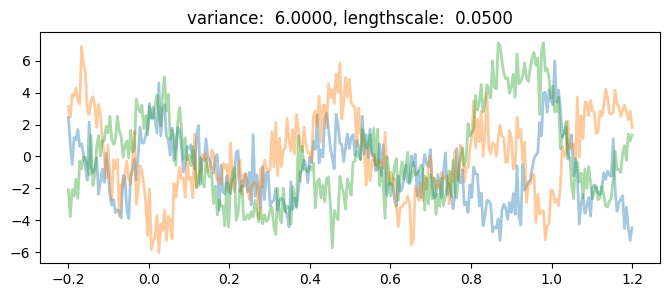

In [307]:
visualise_trajectories(gpr_benchmark_censored, fcn_key_, 3)

In [308]:
gpr_benchmark_censored_res = optimise(gpr_benchmark_censored)

100%|██████████| 2000/2000 [00:12<00:00, 165.53it/s]


variance =  21.333120
lengthscale =  0.100405
noise =  0.005249


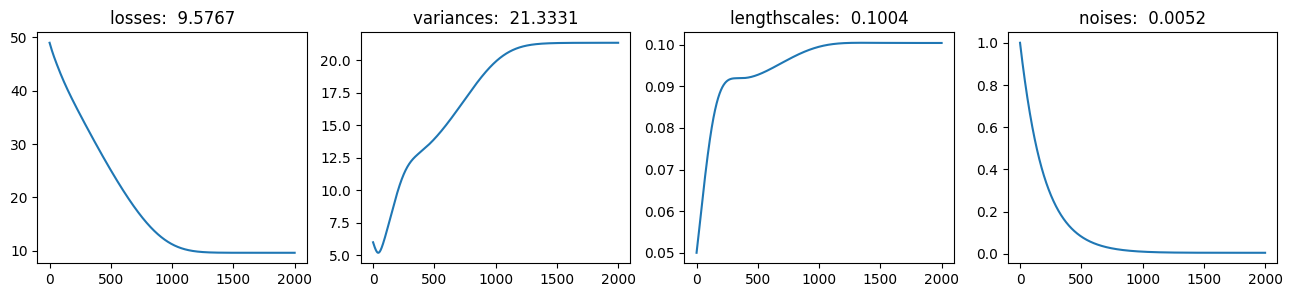

In [309]:
visualise_training(gpr_benchmark_censored_res)

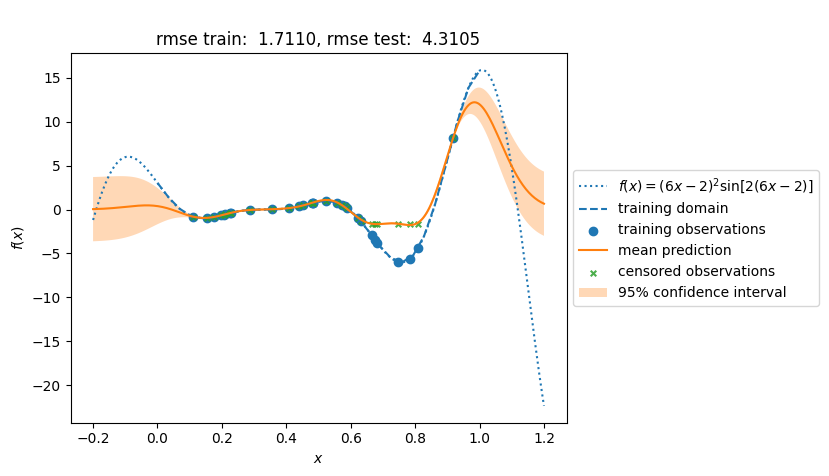

In [342]:
visualise_results(gpr_benchmark_censored_res['model'], grid=X_train_benchmark, labels=y_train_benchmark, censored=y_train_benchmark_censored)

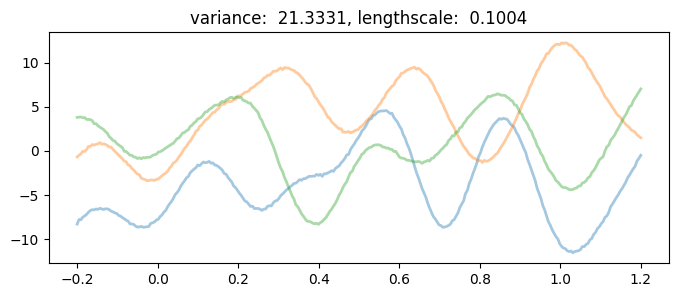

In [311]:
visualise_trajectories(gpr_benchmark_censored, fcn_key_, 3)

#### Bayesian Optimisation

In [312]:
# set parameters for RBF kernel
pyro.clear_param_store()

var_ = 6.
lengthscale_ = 0.05

kernel_censored = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(var_), lengthscale=torch.tensor(lengthscale_))
gpr_censored = gp.models.GPRegression(torch.Tensor(X_train), torch.Tensor(y_train_censored), kernel_censored)

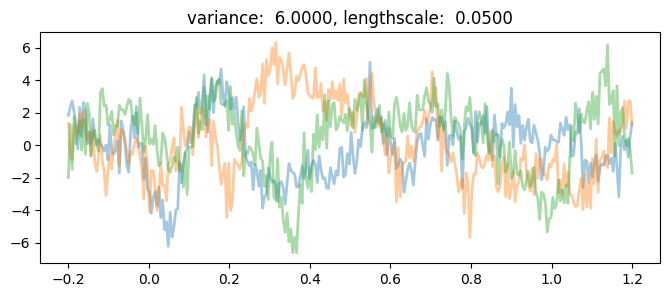

In [313]:
visualise_trajectories(gpr_censored, fcn_key_, 3)

In [314]:
steps_ = N_benchmark - N
print(steps_)
bayes_censored_res = bayes_optimiser(gpr_censored, fcn_key_, steps=steps_)

26


100%|██████████| 2000/2000 [00:10<00:00, 186.75it/s]



variance =  48.063906
lengthscale =  0.119732
noise =  8.043647


  0%|          | 0/26 [00:00<?, ?it/s]

--- Starting optimisation: ----
Selected xmin: 5.100744842031852e-06
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06]) tensor([14.2639, -1.6288,  0.5710,  8.6097,  3.0270])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06])


  4%|▍         | 1/26 [00:05<02:23,  5.74s/it]


variance =  38.800146
lengthscale =  0.089787
noise =  6.092947
Selected xmin: 0.24848180413648835
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01]) tensor([14.2639, -1.6288,  0.5710,  8.6097,  3.0270, -0.2206])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01])


  8%|▊         | 2/26 [00:10<02:07,  5.33s/it]


variance =  31.422807
lengthscale =  0.084822
noise =  5.467687
Selected xmin: 0.5951329982889391
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01]) tensor([ 1.4264e+01, -1.6288e+00,  5.7102e-01,  8.6097e+00,  3.0270e+00,
        -2.2062e-01, -8.2063e-06])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01])


 12%|█▏        | 3/26 [00:16<02:10,  5.69s/it]


variance =  38.066118
lengthscale =  0.169558
noise =  4.052440
Selected xmin: 0.6790660765000396
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01]) tensor([ 1.4264e+01, -1.6288e+00,  5.7102e-01,  8.6097e+00,  3.0270e+00,
        -2.2062e-01, -8.2063e-06, -3.6376e+00])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01])


 15%|█▌        | 4/26 [00:22<02:01,  5.52s/it]


variance =  40.683298
lengthscale =  0.162866
noise =  3.241511
Selected xmin: 0.7018151976830562
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01]) tensor([ 1.4264e+01, -1.6288e+00,  5.7102e-01,  8.6097e+00,  3.0270e+00,
        -2.2062e-01, -8.2063e-06, -3.6376e+00, -4.6831e+00])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01])


 19%|█▉        | 5/26 [00:28<02:03,  5.89s/it]


variance =  39.528997
lengthscale =  0.146345
noise =  3.118553
Selected xmin: 0.7267048233178337
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01]) tensor([ 1.4264e+01, -1.6288e+00,  5.7102e-01,  8.6097e+00,  3.0270e+00,
        -2.2062e-01, -8.2063e-06, -3.6376e+00, -4.6831e+00, -5.5705e+00])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01])


 23%|██▎       | 6/26 [00:34<01:53,  5.70s/it]


variance =  38.816458
lengthscale =  0.128979
noise =  2.960987
Selected xmin: 0.7543403418427245
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01]) tensor([ 1.4264e+01, -1.6288e+00,  5.7102e-01,  8.6097e+00,  3.0270e+00,
        -2.2062e-01, -8.2063e-06, -3.6376e+00, -4.6831e+00, -5.5705e+00,
        -6.0163e+00])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01])


 27%|██▋       | 7/26 [00:39<01:49,  5.77s/it]


variance =  39.895974
lengthscale =  0.117290
noise =  2.411736
Selected xmin: 0.7708152113203377
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01]) tensor([ 1.4264e+01, -1.6288e+00,  5.7102e-01,  8.6097e+00,  3.0270e+00,
        -2.2062e-01, -8.2063e-06, -3.6376e+00, -4.6831e+00, -5.5705e+00,
        -6.0163e+00, -5.9189e+00])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01])


 31%|███       | 8/26 [00:45<01:43,  5.76s/it]


variance =  41.553060
lengthscale =  0.115374
noise =  1.877804
Selected xmin: 0.7718578463924558
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01,
        7.7186e-01]) tensor([ 1.4264e+01, -1.6288e+00,  5.7102e-01,  8.6097e+00,  3.0270e+00,
        -2.2062e-01, -8.2063e-06, -3.6376e+00, -4.6831e+00, -5.5705e+00,
        -6.0163e+00, -5.9189e+00, -5.9023e+00])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01,
        7.7186e-01])


 35%|███▍      | 9/26 [00:50<01:34,  5.58s/it]


variance =  42.871401
lengthscale =  0.116083
noise =  1.531459
Selected xmin: 0.7710228871857508
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01,
        7.7186e-01, 7.7102e-01]) tensor([ 1.4264e+01, -1.6288e+00,  5.7102e-01,  8.6097e+00,  3.0270e+00,
        -2.2062e-01, -8.2063e-06, -3.6376e+00, -4.6831e+00, -5.5705e+00,
        -6.0163e+00, -5.9189e+00, -5.9023e+00, -5.9157e+00])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01,
        7.7186e-01, 7.7102e-01])


 38%|███▊      | 10/26 [00:57<01:34,  5.88s/it]


variance =  43.873483
lengthscale =  0.116999
noise =  1.292702
Selected xmin: 0.7705292283996147
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01,
        7.7186e-01, 7.7102e-01, 7.7053e-01]) tensor([ 1.4264e+01, -1.6288e+00,  5.7102e-01,  8.6097e+00,  3.0270e+00,
        -2.2062e-01, -8.2063e-06, -3.6376e+00, -4.6831e+00, -5.5705e+00,
        -6.0163e+00, -5.9189e+00, -5.9023e+00, -5.9157e+00, -5.9232e+00])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01,
        7.7186e-01, 7.7102e-01, 7.7053e-01])


 42%|████▏     | 11/26 [01:02<01:25,  5.73s/it]


variance =  44.649339
lengthscale =  0.117814
noise =  1.118111
Selected xmin: 0.7702886715483874
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01,
        7.7186e-01, 7.7102e-01, 7.7053e-01, 7.7029e-01]) tensor([ 1.4264e+01, -1.6288e+00,  5.7102e-01,  8.6097e+00,  3.0270e+00,
        -2.2062e-01, -8.2063e-06, -3.6376e+00, -4.6831e+00, -5.5705e+00,
        -6.0163e+00, -5.9189e+00, -5.9023e+00, -5.9157e+00, -5.9232e+00,
        -5.9267e+00])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01,
        7.7186e-01, 7.7102e-01, 7.7053e-01, 7.7029e-01])


 46%|████▌     | 12/26 [01:09<01:22,  5.92s/it]


variance =  45.258821
lengthscale =  0.118492
noise =  0.984864
Selected xmin: 0.7701896660312767
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01,
        7.7186e-01, 7.7102e-01, 7.7053e-01, 7.7029e-01, 7.7019e-01]) tensor([ 1.4264e+01, -1.6288e+00,  5.7102e-01,  8.6097e+00,  3.0270e+00,
        -2.2062e-01, -8.2063e-06, -3.6376e+00, -4.6831e+00, -5.5705e+00,
        -6.0163e+00, -5.9189e+00, -5.9023e+00, -5.9157e+00, -5.9232e+00,
        -5.9267e+00, -5.9282e+00])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01,
        7.7186e-01, 7.7102e-01, 7.7053e-01, 7.7029e-01, 7.7019e-01])


 50%|█████     | 13/26 [01:14<01:14,  5.74s/it]


variance =  45.742152
lengthscale =  0.119046
noise =  0.879828
Selected xmin: 0.7701707782660954
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01,
        7.7186e-01, 7.7102e-01, 7.7053e-01, 7.7029e-01, 7.7019e-01, 7.7017e-01]) tensor([ 1.4264e+01, -1.6288e+00,  5.7102e-01,  8.6097e+00,  3.0270e+00,
        -2.2062e-01, -8.2063e-06, -3.6376e+00, -4.6831e+00, -5.5705e+00,
        -6.0163e+00, -5.9189e+00, -5.9023e+00, -5.9157e+00, -5.9232e+00,
        -5.9267e+00, -5.9282e+00, -5.9285e+00])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01,
        7.7186e-01, 7.7102e-01, 7.7053e-01, 7.7029e-01, 7.7019e-01, 7.7017e-01])


 54%|█████▍    | 14/26 [01:21<01:13,  6.14s/it]


variance =  46.127404
lengthscale =  0.119492
noise =  0.794903
Selected xmin: 0.7701991084832869
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01,
        7.7186e-01, 7.7102e-01, 7.7053e-01, 7.7029e-01, 7.7019e-01, 7.7017e-01,
        7.7020e-01]) tensor([ 1.4264e+01, -1.6288e+00,  5.7102e-01,  8.6097e+00,  3.0270e+00,
        -2.2062e-01, -8.2063e-06, -3.6376e+00, -4.6831e+00, -5.5705e+00,
        -6.0163e+00, -5.9189e+00, -5.9023e+00, -5.9157e+00, -5.9232e+00,
        -5.9267e+00, -5.9282e+00, -5.9285e+00, -5.9281e+00])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01,
        7.7186e-01, 7.7102e-01, 7.7053e-01, 7.7029e-01, 7.7019e-01, 7.7017e-01,
        7.7020e-01])


 58%|█████▊    | 15/26 [01:27<01:05,  5.96s/it]


variance =  46.434790
lengthscale =  0.119848
noise =  0.724821
Selected xmin: 0.770256422058186
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01,
        7.7186e-01, 7.7102e-01, 7.7053e-01, 7.7029e-01, 7.7019e-01, 7.7017e-01,
        7.7020e-01, 7.7026e-01]) tensor([ 1.4264e+01, -1.6288e+00,  5.7102e-01,  8.6097e+00,  3.0270e+00,
        -2.2062e-01, -8.2063e-06, -3.6376e+00, -4.6831e+00, -5.5705e+00,
        -6.0163e+00, -5.9189e+00, -5.9023e+00, -5.9157e+00, -5.9232e+00,
        -5.9267e+00, -5.9282e+00, -5.9285e+00, -5.9281e+00, -5.9272e+00])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01,
        7.7186e-01, 7.7102e-01, 7.7053e-01, 7.7029e-01, 7.7019e-01, 7.7017e-01,
        7.7020e-01, 7.7026e-01])


 62%|██████▏   | 16/26 [01:34<01:02,  6.26s/it]


variance =  46.679233
lengthscale =  0.120128
noise =  0.666005
Selected xmin: 0.7703322776591527
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01,
        7.7186e-01, 7.7102e-01, 7.7053e-01, 7.7029e-01, 7.7019e-01, 7.7017e-01,
        7.7020e-01, 7.7026e-01, 7.7033e-01]) tensor([ 1.4264e+01, -1.6288e+00,  5.7102e-01,  8.6097e+00,  3.0270e+00,
        -2.2062e-01, -8.2063e-06, -3.6376e+00, -4.6831e+00, -5.5705e+00,
        -6.0163e+00, -5.9189e+00, -5.9023e+00, -5.9157e+00, -5.9232e+00,
        -5.9267e+00, -5.9282e+00, -5.9285e+00, -5.9281e+00, -5.9272e+00,
        -5.9261e+00])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01,
        7.7186e-01, 7.7102e-01, 7.7053e-01, 7.7029e-01, 7.7019e-01, 7.7017e-01,
        7.7020e-01, 7.7026e-01, 7.7033e-01])


 65%|██████▌   | 17/26 [01:39<00:54,  6.09s/it]


variance =  46.871988
lengthscale =  0.120344
noise =  0.615944
Selected xmin: 0.7704204671455063
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01,
        7.7186e-01, 7.7102e-01, 7.7053e-01, 7.7029e-01, 7.7019e-01, 7.7017e-01,
        7.7020e-01, 7.7026e-01, 7.7033e-01, 7.7042e-01]) tensor([ 1.4264e+01, -1.6288e+00,  5.7102e-01,  8.6097e+00,  3.0270e+00,
        -2.2062e-01, -8.2063e-06, -3.6376e+00, -4.6831e+00, -5.5705e+00,
        -6.0163e+00, -5.9189e+00, -5.9023e+00, -5.9157e+00, -5.9232e+00,
        -5.9267e+00, -5.9282e+00, -5.9285e+00, -5.9281e+00, -5.9272e+00,
        -5.9261e+00, -5.9248e+00])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01,
        7.7186e-01, 7.7102e-01, 7.7053e-01, 7.7029e-01, 7.7019e-01, 7.7017e-01,
        7.7020e-01, 7.7026e-01, 7.703

 69%|██████▉   | 18/26 [01:45<00:47,  5.97s/it]


variance =  47.021708
lengthscale =  0.120505
noise =  0.572820
Selected xmin: 0.7705172216129117
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01,
        7.7186e-01, 7.7102e-01, 7.7053e-01, 7.7029e-01, 7.7019e-01, 7.7017e-01,
        7.7020e-01, 7.7026e-01, 7.7033e-01, 7.7042e-01, 7.7052e-01]) tensor([ 1.4264e+01, -1.6288e+00,  5.7102e-01,  8.6097e+00,  3.0270e+00,
        -2.2062e-01, -8.2063e-06, -3.6376e+00, -4.6831e+00, -5.5705e+00,
        -6.0163e+00, -5.9189e+00, -5.9023e+00, -5.9157e+00, -5.9232e+00,
        -5.9267e+00, -5.9282e+00, -5.9285e+00, -5.9281e+00, -5.9272e+00,
        -5.9261e+00, -5.9248e+00, -5.9234e+00])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01,
        7.7186e-01, 7.7102e-01, 7.7053e-01, 7.7029e-01, 7.7019e-01, 7.7017e-01,
        7.70

 73%|███████▎  | 19/26 [01:51<00:42,  6.13s/it]


variance =  47.135151
lengthscale =  0.120618
noise =  0.535285
Selected xmin: 0.770620208161218
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01,
        7.7186e-01, 7.7102e-01, 7.7053e-01, 7.7029e-01, 7.7019e-01, 7.7017e-01,
        7.7020e-01, 7.7026e-01, 7.7033e-01, 7.7042e-01, 7.7052e-01, 7.7062e-01]) tensor([ 1.4264e+01, -1.6288e+00,  5.7102e-01,  8.6097e+00,  3.0270e+00,
        -2.2062e-01, -8.2063e-06, -3.6376e+00, -4.6831e+00, -5.5705e+00,
        -6.0163e+00, -5.9189e+00, -5.9023e+00, -5.9157e+00, -5.9232e+00,
        -5.9267e+00, -5.9282e+00, -5.9285e+00, -5.9281e+00, -5.9272e+00,
        -5.9261e+00, -5.9248e+00, -5.9234e+00, -5.9218e+00])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01,
        7.7186e-01, 7.7102e-01, 7.7053e-01, 7.7029e-01, 7.7019e-01, 

 77%|███████▋  | 20/26 [01:57<00:36,  6.09s/it]


variance =  47.217687
lengthscale =  0.120689
noise =  0.502320
Selected xmin: 0.7707280211585198
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01,
        7.7186e-01, 7.7102e-01, 7.7053e-01, 7.7029e-01, 7.7019e-01, 7.7017e-01,
        7.7020e-01, 7.7026e-01, 7.7033e-01, 7.7042e-01, 7.7052e-01, 7.7062e-01,
        7.7073e-01]) tensor([ 1.4264e+01, -1.6288e+00,  5.7102e-01,  8.6097e+00,  3.0270e+00,
        -2.2062e-01, -8.2063e-06, -3.6376e+00, -4.6831e+00, -5.5705e+00,
        -6.0163e+00, -5.9189e+00, -5.9023e+00, -5.9157e+00, -5.9232e+00,
        -5.9267e+00, -5.9282e+00, -5.9285e+00, -5.9281e+00, -5.9272e+00,
        -5.9261e+00, -5.9248e+00, -5.9234e+00, -5.9218e+00, -5.9202e+00])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01,
        7.7186e-01, 7.7102e-01, 7.

 81%|████████  | 21/26 [02:04<00:31,  6.28s/it]


variance =  47.273640
lengthscale =  0.120723
noise =  0.473140
Selected xmin: 0.7708396826233781
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01,
        7.7186e-01, 7.7102e-01, 7.7053e-01, 7.7029e-01, 7.7019e-01, 7.7017e-01,
        7.7020e-01, 7.7026e-01, 7.7033e-01, 7.7042e-01, 7.7052e-01, 7.7062e-01,
        7.7073e-01, 7.7084e-01]) tensor([ 1.4264e+01, -1.6288e+00,  5.7102e-01,  8.6097e+00,  3.0270e+00,
        -2.2062e-01, -8.2063e-06, -3.6376e+00, -4.6831e+00, -5.5705e+00,
        -6.0163e+00, -5.9189e+00, -5.9023e+00, -5.9157e+00, -5.9232e+00,
        -5.9267e+00, -5.9282e+00, -5.9285e+00, -5.9281e+00, -5.9272e+00,
        -5.9261e+00, -5.9248e+00, -5.9234e+00, -5.9218e+00, -5.9202e+00,
        -5.9185e+00])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01,
 

 85%|████████▍ | 22/26 [02:10<00:24,  6.08s/it]


variance =  47.306554
lengthscale =  0.120724
noise =  0.447128
Selected xmin: 0.7709546678574452
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01,
        7.7186e-01, 7.7102e-01, 7.7053e-01, 7.7029e-01, 7.7019e-01, 7.7017e-01,
        7.7020e-01, 7.7026e-01, 7.7033e-01, 7.7042e-01, 7.7052e-01, 7.7062e-01,
        7.7073e-01, 7.7084e-01, 7.7095e-01]) tensor([ 1.4264e+01, -1.6288e+00,  5.7102e-01,  8.6097e+00,  3.0270e+00,
        -2.2062e-01, -8.2063e-06, -3.6376e+00, -4.6831e+00, -5.5705e+00,
        -6.0163e+00, -5.9189e+00, -5.9023e+00, -5.9157e+00, -5.9232e+00,
        -5.9267e+00, -5.9282e+00, -5.9285e+00, -5.9281e+00, -5.9272e+00,
        -5.9261e+00, -5.9248e+00, -5.9234e+00, -5.9218e+00, -5.9202e+00,
        -5.9185e+00, -5.9167e+00])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 

 88%|████████▊ | 23/26 [02:16<00:18,  6.24s/it]


variance =  47.319374
lengthscale =  0.120695
noise =  0.423796
Selected xmin: 0.7710726151107372
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01,
        7.7186e-01, 7.7102e-01, 7.7053e-01, 7.7029e-01, 7.7019e-01, 7.7017e-01,
        7.7020e-01, 7.7026e-01, 7.7033e-01, 7.7042e-01, 7.7052e-01, 7.7062e-01,
        7.7073e-01, 7.7084e-01, 7.7095e-01, 7.7107e-01]) tensor([ 1.4264e+01, -1.6288e+00,  5.7102e-01,  8.6097e+00,  3.0270e+00,
        -2.2062e-01, -8.2063e-06, -3.6376e+00, -4.6831e+00, -5.5705e+00,
        -6.0163e+00, -5.9189e+00, -5.9023e+00, -5.9157e+00, -5.9232e+00,
        -5.9267e+00, -5.9282e+00, -5.9285e+00, -5.9281e+00, -5.9272e+00,
        -5.9261e+00, -5.9248e+00, -5.9234e+00, -5.9218e+00, -5.9202e+00,
        -5.9185e+00, -5.9167e+00, -5.9149e+00])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01,

 92%|█████████▏| 24/26 [02:22<00:11,  5.95s/it]


variance =  47.314599
lengthscale =  0.120639
noise =  0.402750
Selected xmin: 0.7711932579853055
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01,
        7.7186e-01, 7.7102e-01, 7.7053e-01, 7.7029e-01, 7.7019e-01, 7.7017e-01,
        7.7020e-01, 7.7026e-01, 7.7033e-01, 7.7042e-01, 7.7052e-01, 7.7062e-01,
        7.7073e-01, 7.7084e-01, 7.7095e-01, 7.7107e-01, 7.7119e-01]) tensor([ 1.4264e+01, -1.6288e+00,  5.7102e-01,  8.6097e+00,  3.0270e+00,
        -2.2062e-01, -8.2063e-06, -3.6376e+00, -4.6831e+00, -5.5705e+00,
        -6.0163e+00, -5.9189e+00, -5.9023e+00, -5.9157e+00, -5.9232e+00,
        -5.9267e+00, -5.9282e+00, -5.9285e+00, -5.9281e+00, -5.9272e+00,
        -5.9261e+00, -5.9248e+00, -5.9234e+00, -5.9218e+00, -5.9202e+00,
        -5.9185e+00, -5.9167e+00, -5.9149e+00, -5.9130e+00])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
      

 96%|█████████▌| 25/26 [02:29<00:06,  6.25s/it]


variance =  47.294380
lengthscale =  0.120559
noise =  0.383672
Selected xmin: 0.7713164352556808
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.1007e-06, 2.4848e-01,
        5.9513e-01, 6.7907e-01, 7.0182e-01, 7.2670e-01, 7.5434e-01, 7.7082e-01,
        7.7186e-01, 7.7102e-01, 7.7053e-01, 7.7029e-01, 7.7019e-01, 7.7017e-01,
        7.7020e-01, 7.7026e-01, 7.7033e-01, 7.7042e-01, 7.7052e-01, 7.7062e-01,
        7.7073e-01, 7.7084e-01, 7.7095e-01, 7.7107e-01, 7.7119e-01, 7.7132e-01]) tensor([ 1.4264e+01, -1.6288e+00,  5.7102e-01,  8.6097e+00,  3.0270e+00,
        -2.2062e-01, -8.2063e-06, -3.6376e+00, -4.6831e+00, -5.5705e+00,
        -6.0163e+00, -5.9189e+00, -5.9023e+00, -5.9157e+00, -5.9232e+00,
        -5.9267e+00, -5.9282e+00, -5.9285e+00, -5.9281e+00, -5.9272e+00,
        -5.9261e+00, -5.9248e+00, -5.9234e+00, -5.9218e+00, -5.9202e+00,
        -5.9185e+00, -5.9167e+00, -5.9149e+00, -5.9130e+00, -5.9111e+00])
tensor([9.7005e-01, 7.0782e-01, 4.5938e-01, 9.2075e-01, 5.100

100%|██████████| 26/26 [02:34<00:00,  5.96s/it]


variance =  47.260619
lengthscale =  0.120457
noise =  0.366297


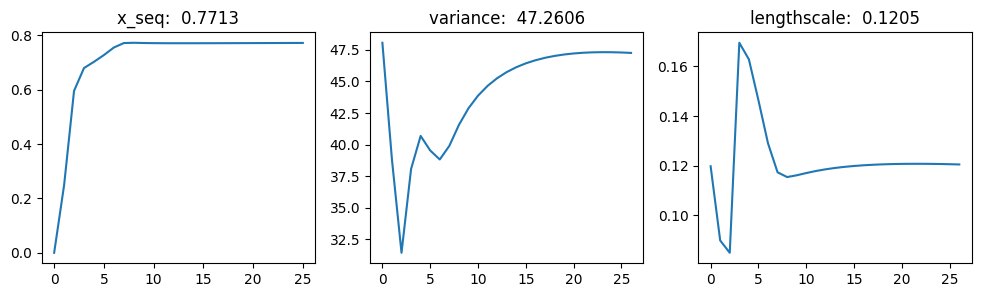

In [315]:
visualise_training(bayes_censored_res)

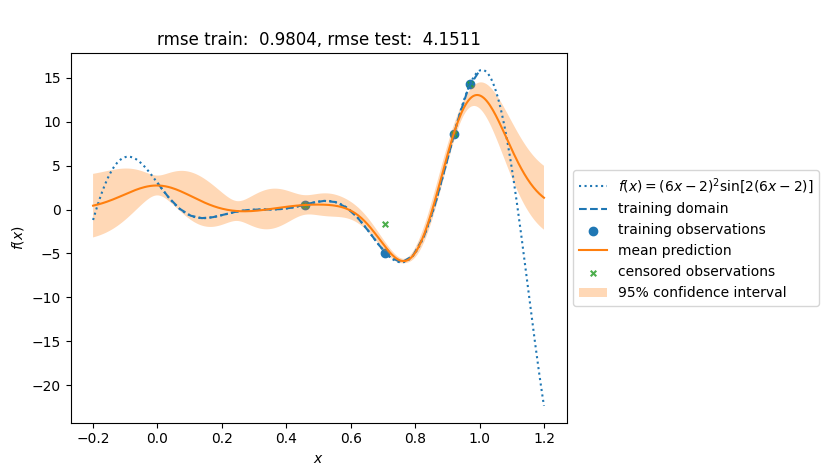

In [343]:
visualise_results(bayes_censored_res['model'], censored=y_train_censored)

## Custom Likelihood

This section uses object `VariationalGP` which supports usage of custom likelihoods.

 * We first check the performance for the Gaussian likelihood to understand the impact of choosing `VariationalGP` object instead of `GPRegressor`.
 * Then we apply explore using Censored Gaussian implementation.

### Non-censored Gaussian

##### Benchmark

In [317]:
likelihood = gp.likelihoods.Gaussian()
likelihood2 = Gaussian()

In [318]:
# set parameters for RBF kernel
var_ = 6.
lengthscale_ = 0.05

In [319]:
kernel_vgp_benchmark = gp.kernels.RBF(
    input_dim=1,
    variance=torch.tensor(var_),
    lengthscale=torch.tensor(lengthscale_))

# own implemented Gaussian likelihood
vgp_benchmark = gp.models.VariationalGP(torch.Tensor(X_train_benchmark), torch.Tensor(y_train_benchmark),
                                       kernel=kernel_vgp_benchmark, likelihood=likelihood2, whiten=True, jitter=1e-06)

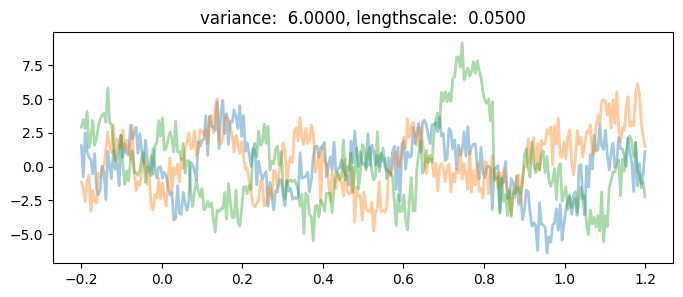

In [320]:
visualise_trajectories(vgp_benchmark, fcn_key_, 3)

In [321]:
vgp_benchmark_res = optimise(vgp_benchmark, 4000)

100%|██████████| 4000/4000 [00:40<00:00, 98.04it/s] 


variance =  7.186468
lengthscale =  0.092666
noise =  0.033071


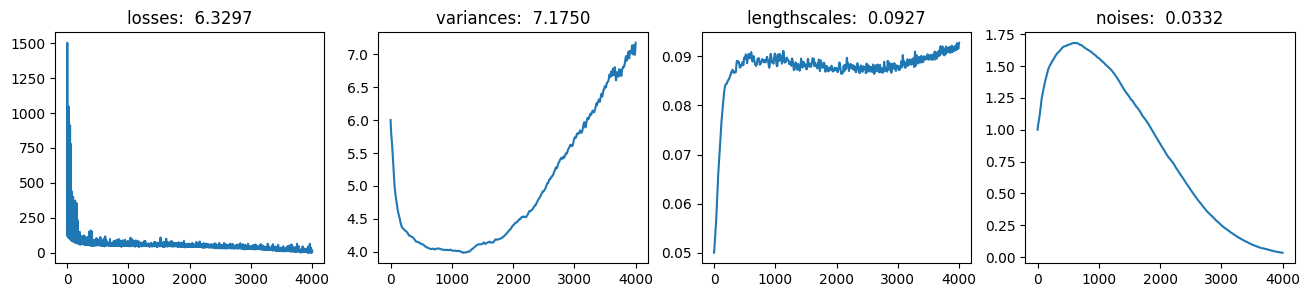

In [322]:
visualise_training(vgp_benchmark_res)

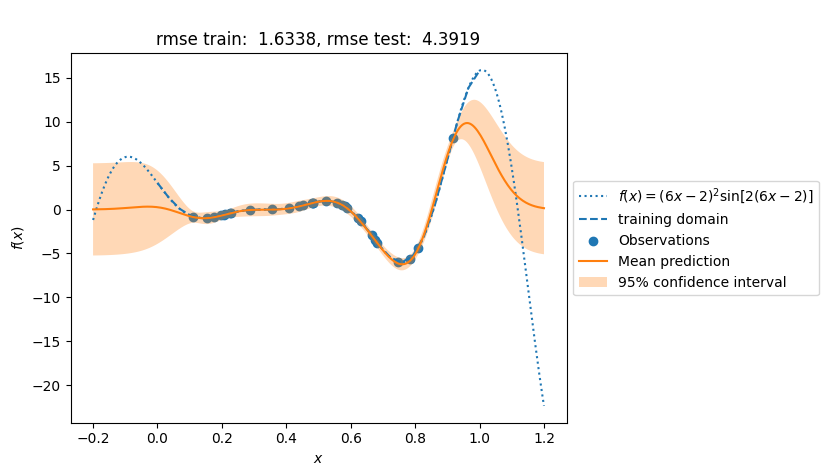

In [323]:
visualise_results(vgp_benchmark_res['model'], grid=X_train_benchmark, labels=y_train_benchmark)

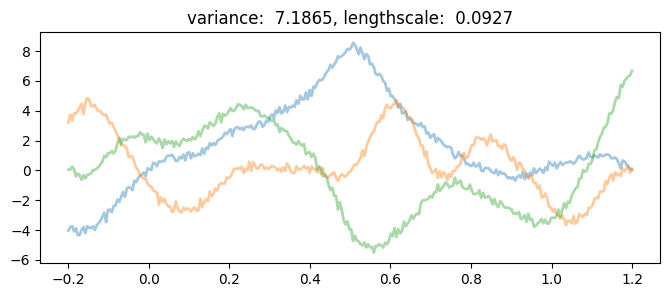

In [324]:
visualise_trajectories(vgp_benchmark_res['model'], fcn_key_, 3)

#### Bayesian Optimisation

In [325]:
# set parameters for RBF kernel
pyro.clear_param_store()

var_ = 6.
lengthscale_ = 0.05

likelihood3 = Gaussian()

kernel_vgp1_bayes = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(var_), lengthscale=torch.tensor(lengthscale_))
vgp1_bayes = gp.models.VariationalGP(torch.Tensor(X_train), torch.Tensor(y_train), kernel_vgp1_bayes, likelihood=likelihood3, whiten=False, jitter=1e-06)

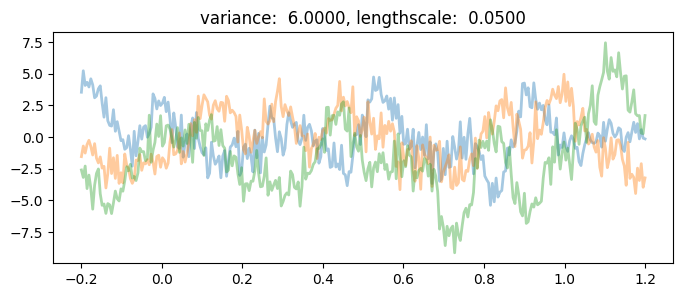

In [326]:
visualise_trajectories(vgp1_bayes, fcn_key_, 3)

In [327]:
# # TODO: fix the numerical instability
# steps_ = N_benchmark - N
# print(steps_)
# vgp1_bayes_res = bayes_optimiser(vgp1_bayes, fcn_key_, steps=steps_)

In [328]:
# visualise_training(vgp1_bayes_res)

In [329]:
# visualise_results(vgp1_bayes_res['model'])

### Censored Gaussian

* two different implementations of ELBO: `pyro.infer.TraceMeanField_ELBO()` and `pyro.infer.Trace_ELBO()`

##### Benchmark

In [330]:
pyro.clear_param_store()

kernel_vgp2_benchmark = gp.kernels.RBF(
    input_dim=1,
    variance=torch.tensor(var_),
    lengthscale=torch.tensor(lengthscale_))

# own implemented Gaussian likelihood
vgp2_benchmark = gp.models.VariationalGP(torch.Tensor(X_train_benchmark), torch.Tensor(y_train_benchmark_censored),
                                       kernel=kernel_vgp2_benchmark, likelihood=likelihood2, whiten=True, jitter=1e-06)

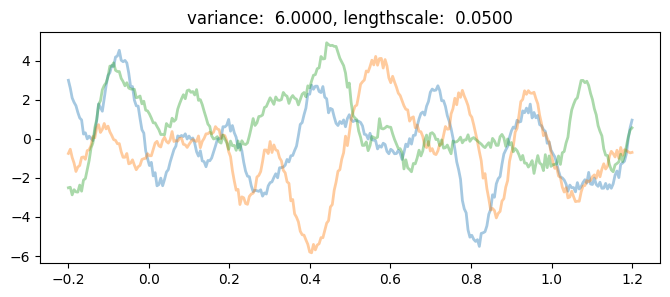

In [331]:
visualise_trajectories(vgp2_benchmark, fcn_key_, 3)

In [332]:
vgp2_benchmark_res = optimise(vgp2_benchmark)

100%|██████████| 2000/2000 [00:27<00:00, 73.95it/s]


variance =  3.496211
lengthscale =  0.104304
noise =  0.069664


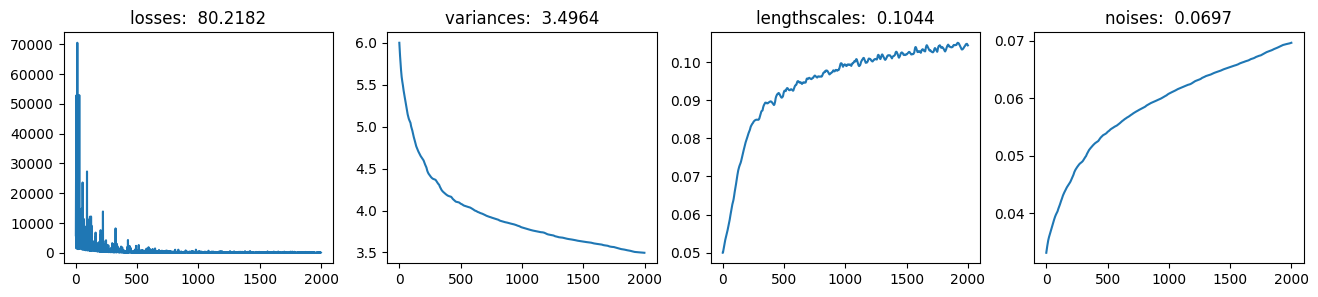

In [333]:
visualise_training(vgp2_benchmark_res)

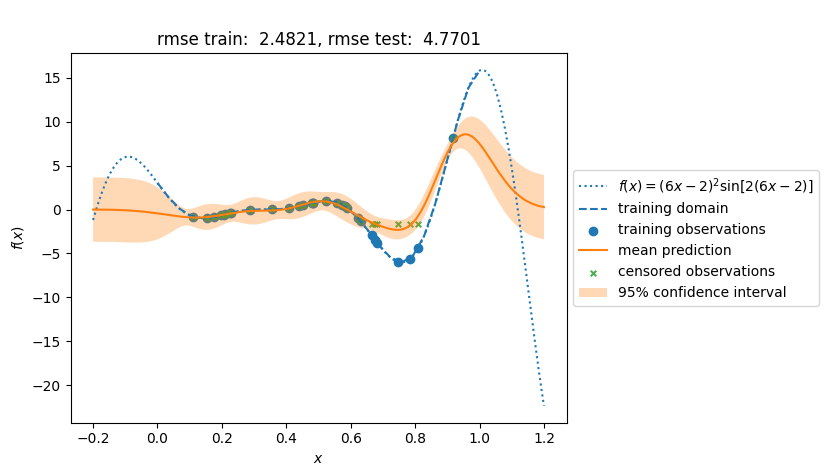

In [344]:
visualise_results(vgp2_benchmark_res['model'], grid=X_train_benchmark, labels=y_train_benchmark, censored=y_train_benchmark_censored)

#### Bayesian Optimisation

In [335]:
pyro.clear_param_store()

var_ = 6.
lengthscale_ = 0.05

kernel_vgp2_bayes = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(var_), lengthscale=torch.tensor(lengthscale_))
vgp2_bayes = gp.models.VariationalGP(torch.Tensor(X_train), torch.Tensor(y_train_censored), kernel_vgp2_bayes, likelihood=likelihood2, whiten=True, jitter=1e-06)

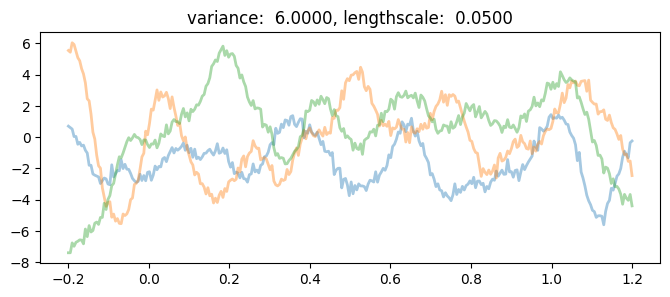

In [336]:
visualise_trajectories(vgp2_bayes, fcn_key_, 3)

In [337]:
# steps_ = N_benchmark - N
# print(steps_)
# vgp2_bayes_res = bayes_optimiser(vgp2_bayes, fcn_key_, steps=steps_)

In [338]:
# visualise_results(vgp2_bayes_res['model'], censored=y_train_censored)